# Tugas Mata Kuliah Deep Learning

### **Nama Anggota Kelompok:**
1. Ahmad Zaki (225150201111025)  
2. Muhammad Razi Al Kindi Nadra (225150207111107)  
3. Arion Syemael Siahaan (225150207111060)  

- Model: Fully Connected Neural Network (FCNN)
- Oversampling: SMOTEENN
- Optimizer: Adam
- Validasi Silang: K-fold cross-validation
- Metode Tambahan: Learning rate scheduler, L1L2 regularizer
- Fungsi Loss: Focal Loss

Data Understanding dan Preliminary Analysis

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K
import os
import seaborn as sns

In [18]:
X_df = pd.read_csv('processed_features.csv')
y_df = pd.read_csv('processed_labels.csv')

X = X_df.values
y = y_df.values.ravel() 

Focal Loss Implementation

In [19]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.cast(y_true, dtype=K.floatx())
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred) + K.epsilon()
        loss = -alpha_t * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(loss)
    return focal_loss_fixed

Create Deep Learning Model

In [24]:
def create_improved_model(input_dim, dropout_rate=0.4):
    keras_model = models.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim,
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate - 0.1),
        layers.Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate - 0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    initial_learning_rate = 0.001  # set your fixed learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)  # directly use learning rate
    
    keras_model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )
    return keras_model


Precision-Recall Curve

In [25]:
def plot_pr_curve(y_true, y_pred_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Training with K-Fold Cross Validation

In [26]:
def train_with_kfold(X, y, n_splits=5):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    histories = []
    models = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f'\nFold {fold + 1}/{n_splits}')
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Apply SMOTEENN
        smote_enn = SMOTEENN(random_state=42)
        X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)
        
        # Calculate class weights
        class_weights = dict(enumerate(np.bincount(y_train_balanced).max() / np.bincount(y_train_balanced)))
        
        # Create and train model
        model = create_improved_model(X_train.shape[1])
        
        history = model.fit(
            X_train_balanced, y_train_balanced,
            epochs=20,
            batch_size=256,
            verbose=0,
            validation_data=(X_val, y_val),
            class_weight=class_weights,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=3,
                    min_lr=1e-6
                )
            ]
        )
        
        histories.append(history.history)
        models.append(model)
    
    return models, histories

Main Pipeline

In [27]:
models, histories = train_with_kfold(X, y)


Fold 1/5


/home/ahmadzaki/anaconda3/envs/bismillah/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 2/5


/home/ahmadzaki/anaconda3/envs/bismillah/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 3/5


/home/ahmadzaki/anaconda3/envs/bismillah/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 4/5


/home/ahmadzaki/anaconda3/envs/bismillah/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 5/5


/home/ahmadzaki/anaconda3/envs/bismillah/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


best model based on validation metrics and final predictions

56504/56504 ━━━━━━━━━━━━━━━━━━━━ 40s 706us/step


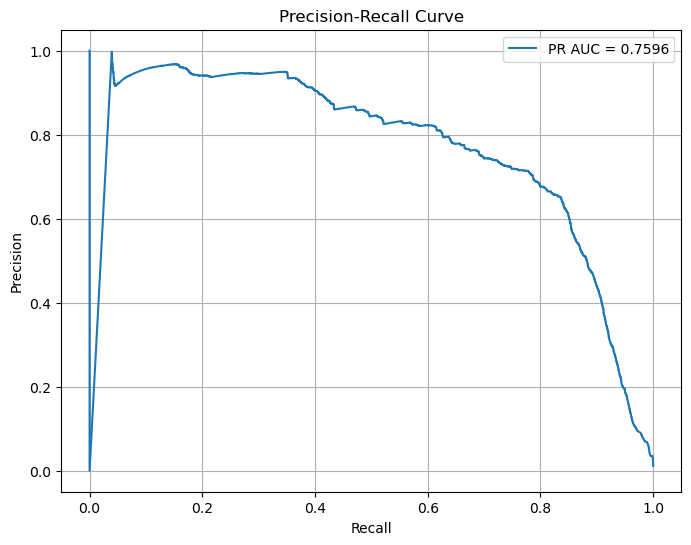

In [28]:
best_model_idx = np.argmax([h['val_accuracy'][-1] for h in histories])
best_model = models[best_model_idx]

y_pred_probs = best_model.predict(X).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)
plot_pr_curve(y, y_pred_probs)

In [29]:
print("\nFinal Classification Report:")
print(classification_report(y, y_pred))


Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1787181
           1       0.49      0.88      0.63     20941

    accuracy                           0.99   1808122
   macro avg       0.74      0.94      0.81   1808122
weighted avg       0.99      0.99      0.99   1808122



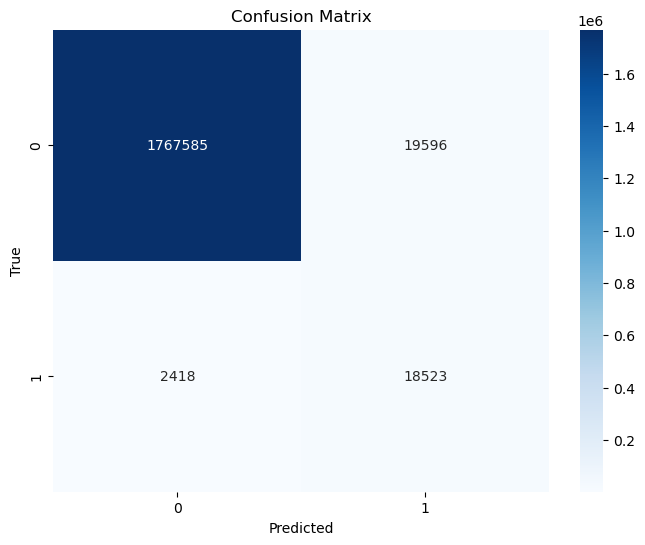

In [34]:
# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [32]:
best_model.save('models/fcnn_smoteenn_adam_kfold_focal_loss_lrscheduler_l1l2_regularizer.h5')
print("Model saved at 'models/fcnn_smoteenn_adam_kfold_focal_loss_lrscheduler_l1l2_regularizer.h5'")

Model saved at 'models/fcnn_smoteenn_adam_kfold_focal_loss_lrscheduler_l1l2_regularizer.h5'
